## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns

## Preparar os dados

In [2]:
data = np.loadtxt("../data/spiral_d.csv", delimiter=",")
X = data[:, :2].T   # 2 x N
y = data[:, 2]      # N
y = np.where(y==1, 1, -1)

print(data.shape)

(1400, 3)


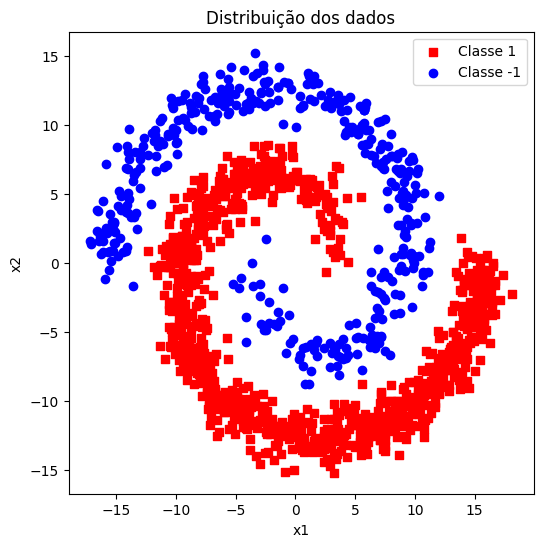

In [3]:
plt.figure(figsize=(6,6))
plt.scatter(X[0, y==1], X[1, y==1], marker='s', color='r', label='Classe 1')
plt.scatter(X[0, y==-1], X[1, y==-1], marker='o', color='b', label='Classe -1')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Distribuição dos dados")
plt.legend()
plt.show()


#### Separando dados

In [4]:
# Particionamento 80% treino, 20% teste
N = X.shape[1]
indices = np.arange(N)
np.random.shuffle(indices)
N_train = int(0.8*N)
train_idx = indices[:N_train]
test_idx  = indices[N_train:]

X_train = X[:, train_idx]
y_train = y[train_idx]

X_test  = X[:, test_idx]
y_test  = y[test_idx]

## Classes

In [11]:
class Perceptron:
    def __init__(self, X_train, y_train, learning_rate=1e-3, plot=True):
        self.p, self.N = X_train.shape
        self.X_train = np.vstack((
            -np.ones((1, self.N)), X_train
        ))
        self.d = y_train
        self.lr = learning_rate
        self.w = np.random.random_sample((self.p+1,1)) - 0.5
        self.plot = plot
        self.x1 = np.linspace(-2, 10)
        
        if plot:
            self.fig = plt.figure(1)
            self.ax = self.fig.add_subplot()
            self.ax.scatter(self.X_train[1, self.d[:]==1],
                            self.X_train[2, self.d[:]==1], marker='s', s=120)
            self.ax.scatter(self.X_train[1, self.d[:]==-1],
                            self.X_train[2, self.d[:]==-1], marker='o', s=120)
            self.ax.set_xlim(-1, 7)
            self.ax.set_ylim(-1, 7)
            self.draw_line()
        
    def draw_line(self, c='k', alpha=1, lw=2):
        x2 = -self.w[1,0]/self.w[2,0]*self.x1 + self.w[0,0]/self.w[2,0]
        x2 = np.nan_to_num(x2)
        if self.plot:
            plt.plot(self.x1, x2, c=c, alpha=alpha, lw=lw)
        
    def activation_function(self, u):
        return 1 if u >= 0 else -1
    
    def fit(self):
        epochs = 0
        error = True
        while error:
            error = False
            for k in range(self.N):
                x_k = self.X_train[:, k].reshape(self.p+1, 1)
                u_k = (self.w.T @ x_k)[0,0]
                y_k = self.activation_function(u_k)
                d_k = self.d[k]
                e_k = d_k - y_k
                if e_k != 0:
                    error = True
                self.w = self.w + self.lr * e_k * x_k
            
            if self.plot:
                plt.pause(.4)
                self.draw_line(c='r', alpha=.5)
            epochs += 1
        
        if self.plot:
            plt.pause(.4)
            self.draw_line(c='g', alpha=1, lw=4)
            plt.show()
        print(f'Treinamento concluído em {epochs} épocas.')

In [6]:
class MultilayerPerceptron:
    def __init__(self,X_train:np.ndarray, Y_train:np.ndarray, topology:list, learning_rate = 1e-3, max_epoch=10000, tol = 1e-12):
        '''
        X_train (p x N)
        Y_train (C x N) ou (1 x N) se classificação binária
        '''
        self.p , self.N = X_train.shape
        self.m = Y_train.shape[0]
        
        self.X_train = np.vstack((
            -np.ones((1,self.N)),X_train
        ))
        self.tol = tol
        self.lr = learning_rate
        self.d = Y_train
        topology.append(self.m)
        self.W = [None]*len(topology)
        Z = 0
        for i in range(len(self.W)):
            if i == 0:
                W = np.random.random_sample((topology[i],self.p+1))-.5
            else:
                W = np.random.random_sample((topology[i],topology[i-1]+1))-.5
            self.W[i] = W
            Z += W.size
        print(f"Rede MLP com {Z} parâmetros")
        self.max_epoch = max_epoch
        self.y = [None]*len(topology)
        self.u = [None]*len(topology)
        self.delta = [None]*len(topology)
        
    def g(self, u):
        return (1-np.exp(-u))/(1+np.exp(-u))
    
    def g_d(self, u):
        y = self.g(u)
        return .5*(1-y**2)
    
    def backward(self, e,x):
        for i in range(len(self.W)-1,-1,-1):
            if i == len(self.W)-1:
                self.delta[i] = self.g_d(self.u[i]) * e
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            elif i == 0:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@x.T)
                
            else:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            
    
    def forward(self, x):
        
        for i,W in enumerate(self.W):
            if i == 0:
                self.u[i] = W@x
            else:
                yb = np.vstack((
                    -np.ones((1,1)), self.y[i-1]
                ))
                self.u[i] = W@yb                
            self.y[i] = self.g(self.u[i])
         
        
        
    def EQM(self):
        s = 0
        for k in range(self.N):
            x_k = self.X_train[:,k].reshape(self.p+1,1)
            self.forward(x_k)
            y = self.y[-1]
            d = self.d[:,k].reshape(self.m,1)
            e = d - y
            s += np.sum(e**2)
        return s/(2*self.N)
        
    def fit(self):
        epoch = 0
        EQM1 = 1
        self.history = []
        
        while epoch < self.max_epoch and EQM1>self.tol:
            t1 = time()
            for k in range(self.N):
                x_k = self.X_train[:,k].reshape(self.p+1,1)
                #Forward
                self.forward(x_k)
                y = self.y[-1]
                d = self.d[:,k].reshape(self.m,1)
                e = d - y
                #Backward
                self.backward(e,x_k)
            t2 = time()
            EQM1 = self.EQM()
            self.history.append(EQM1)
            epoch+=1
            print(f"Tempo: {t2-t1:.5f}s  Época: {epoch}, EQM: {EQM1:.15f}")

    def predict(self, X):
        """
        Faz a predição para novos dados X (p x N_test)
        Retorna uma matriz de saída (m x N_test)
        """
        N_test = X.shape[1]

        X_bias = np.vstack((-np.ones((1, N_test)), X))
        
        Y_pred = np.zeros((self.m, N_test))
        
        for k in range(N_test):
            x_k = X_bias[:, k].reshape(self.p+1, 1)
            self.forward(x_k)
            Y_pred[:, k] = self.y[-1][:, 0]
        
        return Y_pred


In [ ]:
perceptron = Perceptron(X_train=X_train, y_train=y_train, learning_rate=0.01, plot=False)
perceptron.fit()

In [ ]:
# Função para predição
def predict_perceptron(model, X):
    N = X.shape[1]
    y_pred = np.zeros(N)
    for i in range(N):
        x_i = np.vstack((-np.ones((1,1)), X[:,i].reshape(-1,1)))
        y_pred[i] = model.activation_function((model.w.T @ x_i)[0,0])
    return y_pred

# Predição
y_pred_train = predict_perceptron(perceptron, X_train)
y_pred_test  = predict_perceptron(perceptron, X_test)

# Matrizes de confusão (manual)
def confusion_matrix_manual(y_true, y_pred):
    TP = np.sum((y_true==1) & (y_pred==1))
    TN = np.sum((y_true==-1) & (y_pred==-1))
    FP = np.sum((y_true==-1) & (y_pred==1))
    FN = np.sum((y_true==1) & (y_pred==-1))
    return np.array([[TP, FP],
                     [FN, TN]])

cm_train = confusion_matrix_manual(y_train, y_pred_train)
cm_test  = confusion_matrix_manual(y_test, y_pred_test)

# Métricas
def metrics(cm):
    TP, FP = cm[0]
    FN, TN = cm[1]
    acc = (TP+TN)/(TP+TN+FP+FN)
    sens = TP/(TP+FN) if (TP+FN)!=0 else 0
    spec = TN/(TN+FP) if (TN+FP)!=0 else 0
    prec = TP/(TP+FP) if (TP+FP)!=0 else 0
    f1 = 2*prec*sens/(prec+sens) if (prec+sens)!=0 else 0
    return acc, sens, spec, prec, f1

acc_train, sens_train, spec_train, prec_train, f1_train = metrics(cm_train)
acc_test, sens_test, spec_test, prec_test, f1_test = metrics(cm_test)

print("Perceptron - Treino")
print("CM:\n", cm_train)
print(f"Acurácia: {acc_train:.3f}, Sensibilidade: {sens_train:.3f}, Especificidade: {spec_train:.3f}, Precisão: {prec_train:.3f}, F1: {f1_train:.3f}\n")

print("Perceptron - Teste")
print("CM:\n", cm_test)
print(f"Acurácia: {acc_test:.3f}, Sensibilidade: {sens_test:.3f}, Especificidade: {spec_test:.3f}, Precisão: {prec_test:.3f}, F1: {f1_test:.3f}")


In [ ]:
# Preparar labels para MLP (1 x N)
Y_train_mlp = y_train.reshape(1, -1)
Y_test_mlp  = y_test.reshape(1, -1)

# Criar MLP (topologia: camada oculta com 5 neurônios)
mlp = MultilayerPerceptron(X_train=X_train, Y_train=Y_train_mlp, topology=[5], learning_rate=0.01, max_epoch=500)
mlp.fit()


In [ ]:
# Predição
Y_pred_train_raw = mlp.predict(X_train)
Y_pred_test_raw  = mlp.predict(X_test)

# Convertendo saída para {-1,1}
y_pred_train_mlp = np.where(Y_pred_train_raw[0,:]>=0, 1, -1)
y_pred_test_mlp  = np.where(Y_pred_test_raw[0,:]>=0, 1, -1)

# Matrizes de confusão
cm_train_mlp = confusion_matrix_manual(y_train, y_pred_train_mlp)
cm_test_mlp  = confusion_matrix_manual(y_test, y_pred_test_mlp)

acc_train_mlp, sens_train_mlp, spec_train_mlp, prec_train_mlp, f1_train_mlp = metrics(cm_train_mlp)
acc_test_mlp, sens_test_mlp, spec_test_mlp, prec_test_mlp, f1_test_mlp = metrics(cm_test_mlp)

print("MLP - Treino")
print("CM:\n", cm_train_mlp)
print(f"Acurácia: {acc_train_mlp:.3f}, Sensibilidade: {sens_train_mlp:.3f}, Especificidade: {spec_train_mlp:.3f}, Precisão: {prec_train_mlp:.3f}, F1: {f1_train_mlp:.3f}\n")

print("MLP - Teste")
print("CM:\n", cm_test_mlp)
print(f"Acurácia: {acc_test_mlp:.3f}, Sensibilidade: {sens_test_mlp:.3f}, Especificidade: {spec_test_mlp:.3f}, Precisão: {prec_test_mlp:.3f}, F1: {f1_test_mlp:.3f}")


In [ ]:
plt.figure()
plt.plot(mlp.history)
plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curva de aprendizado MLP")
plt.show()
